# Marketing

In [ ]:
матрицу уточнить ошибки посмотреть запись еще раз

## Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов необходимо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Бизнес-задача:**  
Предсказать вероятность покупки в течение 90 дней.

---

## Задачи

- Изучить данные  
- Разработать полезные признаки  
- Создать модель для классификации пользователей  
- Улучшить модель и максимизировать метрику `roc_auc`  
- Выполнить тестирование  

---

## Данные

### apparel-purchases  
История покупок  
- `client_id` — идентификатор пользователя  
- `quantity` — количество товаров в заказе  
- `price` — цена товара  
- `category_ids` — вложенные категории, к которым относится товар  
- `date` — дата покупки  
- `message_id` — идентификатор сообщения из рассылки  

### apparel-messages  
История рекламных рассылок  
- `bulk_campaign_id` — идентификатор рекламной кампании  
- `client_id` — идентификатор пользователя  
- `message_id` — идентификатор сообщения  
- `event` — тип действия  
- `channel` — канал рассылки  
- `date` — дата рассылки  
- `created_at` — точное время создания сообщения  

### apparel-target_binary  
Совершит ли клиент покупку в течение следующих 90 дней  
- `client_id` — идентификатор пользователя  
- `target` — целевой признак  

### full_campaign_daily_event  
Агрегация общей базы рассылок по дням и типам событий  
- `date` — дата  
- `bulk_campaign_id` — идентификатор рассылки  
- `count_event*` — общее количество каждого события `event`  
- `nunique_event*` — количество уникальных `client_id` в каждом событии  

### full_campaign_daily_event_channel  
Агрегация по дням с учетом событий и каналов рассылки  
- `date` — дата  
- `bulk_campaign_id` — идентификатор рассылки  
- `count_event*_channel*` — общее количество каждого события по каналам  
- `nunique_event*_channel*` — количество уникальных `client_id` по событиям и каналам  


## Загрузка данных

In [170]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler



from sklearn.utils import resample

from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import catboost

import lightgbm as lgb


from lightgbm import early_stopping, log_evaluation

In [3]:
# Основная директория
#base_path = '/Users/migdalia/goinfre/description/filtered_data'
base_path = '/Users/shogun/Desktop/ds_projects/masterskaya2/filtered_data'

# Файлы
file1 = 'apparel-messages.csv'
file2 = 'apparel-purchases.csv'
file3 = 'apparel-target_binary.csv'
file4 = 'full_campaign_daily_event_channel.csv'
file5 = 'full_campaign_daily_event.csv'

# Полные пути
path1 = os.path.join(base_path, file1)
path2 = os.path.join(base_path, file2)
path3 = os.path.join(base_path, file3)
path4 = os.path.join(base_path, file4)
path5 = os.path.join(base_path, file5)

In [4]:
if os.path.exists(path1):
    messages = pd.read_csv(path1)
    print(f'[1] Загружен {file1}')
else:
    print(f'[ERROR1] {file1} не найден')

    
if os.path.exists(path2):
    purchases = pd.read_csv(path2)
    print(f'[2] Загружен {file2}')
else:
    print(f'[ERROR2] {file2} не найден')

if os.path.exists(path3):
    target = pd.read_csv(path3)
    print(f'[3] Загружен {file3}')
else:
    print(f'[ERROR3] {file3} не найден')

    
if os.path.exists(path4):
    agg_event = pd.read_csv(path4)
    print(f'[4] Загружен {file4}')
else:
    print(f'[ERROR4] {file4} не найден')
    
if os.path.exists(path5):
    agg_event_channel = pd.read_csv(path5)
    print(f'[5] Загружен {file5}')
else:
    print(f'[ERROR5] {file5} не найден')

[OK1] Загружен apparel-messages.csv
[OK2] Загружен apparel-purchases.csv
[OK3] Загружен apparel-target_binary.csv
[OK4] Загружен full_campaign_daily_event_channel.csv
[OK5] Загружен full_campaign_daily_event.csv


## Просмотр данных

In [6]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [13]:
messages.shape[0]

12739798

In [14]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [5]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [11]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [7]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [9]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [19]:
target.target.value_counts()

target
0    48888
1      961
Name: count, dtype: int64

In [15]:
agg_event.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
agg_event.shape[0]

131072

In [8]:
agg_event_channel.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [29]:
agg_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [17]:
agg_event_channel.shape[0]

131072

In [26]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [32]:
messages.event.value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [ ]:
messages = messages.query('event != "close"')


## Соединение таблиц по Customer-Level Modeling 

In [ ]:
Будем предсказывать, сделает ли клиент покупку в течение 90 после получения рассылки. Поэтому будем соединять по client_id

### преобразуем messages: 1 таблица

In [59]:
messages.channel.unique()

array(['email', 'mobile_push'], dtype=object)

In [49]:
messages = messages[['client_id', 'message_id', 'event', 'channel', 'date']]


In [97]:
df_event_counts = (
    messages
    .groupby(['client_id', 'event', 'channel'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)


In [98]:
df_event_counts

channel,client_id,event,email,mobile_push
0,1515915625468060902,click,10,0
1,1515915625468060902,open,35,0
2,1515915625468060902,purchase,5,0
3,1515915625468060902,send,126,0
4,1515915625468060902,unsubscribe,1,0
...,...,...,...,...
206129,1515915626010261344,click,0,1
206130,1515915626010261344,open,0,1
206131,1515915626010261344,send,0,1
206132,1515915626010288690,open,0,1


In [95]:
if 'df_messages' in globals():
    del df_messages

In [102]:
df_messages = (
    df_event_counts
    .pivot(index='client_id', columns='event')[['email', 'mobile_push']]
)


In [100]:
df_messages

channel             email                                                     \
event               click close complain hard_bounce hbq_spam  open purchase   
client_id                                                                      
1515915625468060902  10.0   NaN      NaN         NaN      NaN  35.0      5.0   
1515915625468061003   6.0   NaN      NaN         NaN      NaN   5.0      1.0   
1515915625468061099   8.0   NaN      NaN         0.0      NaN  17.0      NaN   
1515915625468061100   0.0   NaN      NaN         0.0      NaN   0.0      0.0   
1515915625468061170  16.0   NaN      NaN         NaN      NaN  19.0      3.0   
...                   ...   ...      ...         ...      ...   ...      ...   
1515915626010183608   NaN   NaN      NaN         NaN      NaN   0.0      NaN   
1515915626010221592   0.0   NaN      NaN         NaN      NaN   0.0      NaN   
1515915626010234726   NaN   NaN      NaN         NaN      NaN   NaN      NaN   
1515915626010261344   0.0   NaN      NaN         NaN      NaN   0.0      NaN   
1515915626010288690   NaN   NaN      NaN         NaN      NaN   0.0      NaN   

channel                                           ... mobile_push           \
event                 send soft_bounce subscribe  ...       close complain   
client_id                                         ...                        
1515915625468060902  126.0         NaN       NaN  ...         NaN      NaN   
1515915625468061003  154.0         NaN       NaN  ...         NaN      NaN   
1515915625468061099  157.0         NaN       NaN  ...         NaN      NaN   
1515915625468061100    0.0         0.0       NaN  ...         NaN      NaN   
1515915625468061170  164.0         NaN       NaN  ...         NaN      NaN   
...                    ...         ...       ...  ...         ...      ...   
1515915626010183608    0.0         NaN       NaN  ...         NaN      NaN   
1515915626010221592    0.0         NaN       NaN  ...         NaN      NaN   
1515915626010234726    0.0         NaN       NaN  ...         NaN      NaN   
1515915626010261344    0.0         NaN       NaN  ...         NaN      NaN   
1515915626010288690    0.0         NaN       NaN  ...         NaN      NaN   

channel                                                                      \
event               hard_bounce hbq_spam   open purchase   send soft_bounce   
client_id                                                                     
1515915625468060902         NaN      NaN    0.0      0.0    0.0         NaN   
1515915625468061003         NaN      NaN    0.0      0.0    0.0         NaN   
1515915625468061099         2.0      NaN   34.0      NaN   58.0         NaN   
1515915625468061100         1.0      NaN  163.0      1.0  267.0         1.0   
1515915625468061170         NaN      NaN   12.0      0.0   79.0         NaN   
...                         ...      ...    ...      ...    ...         ...   
1515915626010183608         NaN      NaN    2.0      NaN    2.0         NaN   
1515915626010221592         NaN      NaN    2.0      NaN    2.0         NaN   
1515915626010234726         NaN      NaN    NaN      NaN    1.0         NaN   
1515915626010261344         NaN      NaN    1.0      NaN    1.0         NaN   
1515915626010288690         NaN      NaN    1.0      NaN    1.0         NaN   

channel                                    
event               subscribe unsubscribe  
client_id                                  
1515915625468060902       NaN         0.0  
1515915625468061003       NaN         NaN  
1515915625468061099       NaN         NaN  
1515915625468061100       NaN         NaN  
1515915625468061170       NaN         NaN  
...                       ...         ...  
1515915626010183608       NaN         NaN  
1515915626010221592       NaN         NaN  
1515915626010234726       NaN         NaN  
1515915626010261344       NaN         NaN  
1515915626010288690       NaN         NaN  

[53329 rows x 22 columns]

In [103]:

# Расплющим MultiIndex в колонках
df_messages.columns = [f"{event}_{channel}" for channel, event in df_messages.columns]

# Заполним пропуски (если какие-то client_id не имели событий)
df_messages = df_messages.fillna(0).astype(int).reset_index()


In [104]:
df_messages

,client_id,click_email,close_email,complain_email,hard_bounce_email,hbq_spam_email,open_email,purchase_email,send_email,soft_bounce_email,...,close_mobile_push,complain_mobile_push,hard_bounce_mobile_push,hbq_spam_mobile_push,open_mobile_push,purchase_mobile_push,send_mobile_push,soft_bounce_mobile_push,subscribe_mobile_push,unsubscribe_mobile_push
0,1515915625468060902,10,0,0,0,0,35,5,126,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468061003,6,0,0,0,0,5,1,154,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468061099,8,0,0,0,0,17,0,157,0,...,0,0,2,0,34,0,58,0,0,0
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,0,0,1,0,163,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,19,3,164,0,...,0,0,0,0,12,0,79,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,0
53325,1515915626010221592,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,0
53326,1515915626010234726,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
53327,1515915626010261344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [79]:
messages

,client_id,message_id,event,channel,date
0,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19
...,...,...,...,...,...
12739793,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15
12739794,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15
12739795,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15
12739796,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15


In [105]:
df_dates = messages.groupby('client_id')['date'].agg(
    first_date_mes='min',
    last_date_mes='max'
)
df_dates.first_date_mes = pd.to_datetime(df_dates.first_date_mes)
df_dates.last_date_mes = pd.to_datetime(df_dates.last_date_mes)
df_dates['messages_duration'] = df_dates['last_date_mes'] - df_dates['first_date_mes']


In [106]:
df_final = df_messages.join(df_dates, on='client_id')


In [107]:
df_final.head()

,client_id,click_email,close_email,complain_email,hard_bounce_email,hbq_spam_email,open_email,purchase_email,send_email,soft_bounce_email,...,hbq_spam_mobile_push,open_mobile_push,purchase_mobile_push,send_mobile_push,soft_bounce_mobile_push,subscribe_mobile_push,unsubscribe_mobile_push,first_date_mes,last_date_mes,messages_duration
0,1515915625468060902,10,0,0,0,0,35,5,126,0,...,0,0,0,0,0,0,0,2022-05-19,2024-01-19,610 days
1,1515915625468061003,6,0,0,0,0,5,1,154,0,...,0,0,0,0,0,0,0,2022-05-20,2024-02-13,634 days
2,1515915625468061099,8,0,0,0,0,17,0,157,0,...,0,34,0,58,0,0,0,2022-05-19,2024-02-13,635 days
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,0,163,1,267,1,0,0,2022-05-19,2024-02-15,637 days
4,1515915625468061170,16,0,0,0,0,19,3,164,0,...,0,12,0,79,0,0,0,2022-05-25,2024-02-15,631 days


### Преобразуем покупки: 2 таблица

In [108]:
agg_purchases = purchases.groupby('client_id').agg({
    'quantity': 'sum',
    'price': ['sum', 'mean'],
    'date': ['min', 'max', 'nunique'],
    'message_id': 'nunique',
    'category_ids': lambda x: len(set(x))
})


# Переименуем колонки
agg_purchases.columns = [
    'quantity_sum',
    'price_sum', 'price_mean',
    'first_purchase_date', 'last_purchase_date', 'n_purchase_days',
    'n_message_ids',
    'n_unique_categories'
]

agg_purchases['last_purchase_date'] = pd.to_datetime(agg_purchases['last_purchase_date'])
agg_purchases['first_purchase_date'] = pd.to_datetime(agg_purchases['first_purchase_date'])

# Рассчитаем число покупок (по числу строк)
agg_purchases['n_orders'] = purchases.groupby('client_id').size()

# Добавим lifetime в днях
agg_purchases['purchase_lifetime_days'] = (
    agg_purchases['last_purchase_date'] - agg_purchases['first_purchase_date']
).dt.days

# (опционально) Средний чек за покупку
agg_purchases['avg_check'] = agg_purchases['price_sum'] / agg_purchases['n_orders']

In [109]:
agg_purchases.head(5)

,quantity_sum,price_sum,price_mean,first_purchase_date,last_purchase_date,n_purchase_days,n_message_ids,n_unique_categories,n_orders,purchase_lifetime_days,avg_check
client_id,,,,,,,,,,,
1515915625468060902,7,6993.0,999.000000,2022-05-27,2022-05-27,1,1,5,7,0,999.000000
1515915625468061003,7,16235.0,2319.285714,2023-01-04,2023-01-04,1,1,1,7,0,2319.285714
1515915625468061099,1,299.0,299.000000,2022-05-17,2022-05-17,1,1,1,1,0,299.000000
1515915625468061100,2,2098.0,1049.000000,2024-02-10,2024-02-10,1,1,1,2,0,1049.000000
1515915625468061170,19,33601.0,1768.473684,2023-03-26,2023-06-17,3,3,4,19,83,1768.473684


### Соединяем 1 таблицу со 2 таблицей

In [112]:
df_final2 = df_final.merge(agg_purchases, how='left', on='client_id')

## Финальный дф

In [180]:
df = df_final2.merge(target, how='left', on='client_id')

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   client_id                53329 non-null  int64          
 1   click_email              53329 non-null  int64          
 2   close_email              53329 non-null  int64          
 3   complain_email           53329 non-null  int64          
 4   hard_bounce_email        53329 non-null  int64          
 5   hbq_spam_email           53329 non-null  int64          
 6   open_email               53329 non-null  int64          
 7   purchase_email           53329 non-null  int64          
 8   send_email               53329 non-null  int64          
 9   soft_bounce_email        53329 non-null  int64          
 10  subscribe_email          53329 non-null  int64          
 11  unsubscribe_email        53329 non-null  int64          
 12  click_mobile_push 

In [182]:
df.head()

,client_id,click_email,close_email,complain_email,hard_bounce_email,hbq_spam_email,open_email,purchase_email,send_email,soft_bounce_email,...,price_mean,first_purchase_date,last_purchase_date,n_purchase_days,n_message_ids,n_unique_categories,n_orders,purchase_lifetime_days,avg_check,target
0,1515915625468060902,10,0,0,0,0,35,5,126,0,...,999.000000,2022-05-27,2022-05-27,1.0,1.0,5.0,7.0,0.0,999.000000,0.0
1,1515915625468061003,6,0,0,0,0,5,1,154,0,...,2319.285714,2023-01-04,2023-01-04,1.0,1.0,1.0,7.0,0.0,2319.285714,1.0
2,1515915625468061099,8,0,0,0,0,17,0,157,0,...,299.000000,2022-05-17,2022-05-17,1.0,1.0,1.0,1.0,0.0,299.000000,0.0
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,1049.000000,2024-02-10,2024-02-10,1.0,1.0,1.0,2.0,0.0,1049.000000,0.0
4,1515915625468061170,16,0,0,0,0,19,3,164,0,...,1768.473684,2023-03-26,2023-06-17,3.0,3.0,4.0,19.0,83.0,1768.473684,0.0


Все к инту, заполняя пропуски нулями

In [183]:
float_cols = df.select_dtypes(include=['float']).columns

df[float_cols] = df[float_cols].fillna(0).round().astype('int')


## Корреляция признаков

In [184]:
corr_matrix = df.corr()
print(corr_matrix)


                         client_id  click_email  close_email  complain_email  \
client_id                 1.000000    -0.156119          NaN       -0.012687   
click_email              -0.156119     1.000000          NaN       -0.002540   
close_email                    NaN          NaN          NaN             NaN   
complain_email           -0.012687    -0.002540          NaN        1.000000   
hard_bounce_email        -0.019604    -0.019165          NaN       -0.000725   
hbq_spam_email           -0.044664     0.031528          NaN       -0.002100   
open_email               -0.182524     0.519563          NaN       -0.004545   
purchase_email           -0.186107     0.531725          NaN        0.004115   
send_email               -0.415519     0.357593          NaN       -0.004974   
soft_bounce_email        -0.022541    -0.007356          NaN       -0.001322   
subscribe_email          -0.007599     0.012208          NaN        0.000151   
unsubscribe_email        -0.037225     0

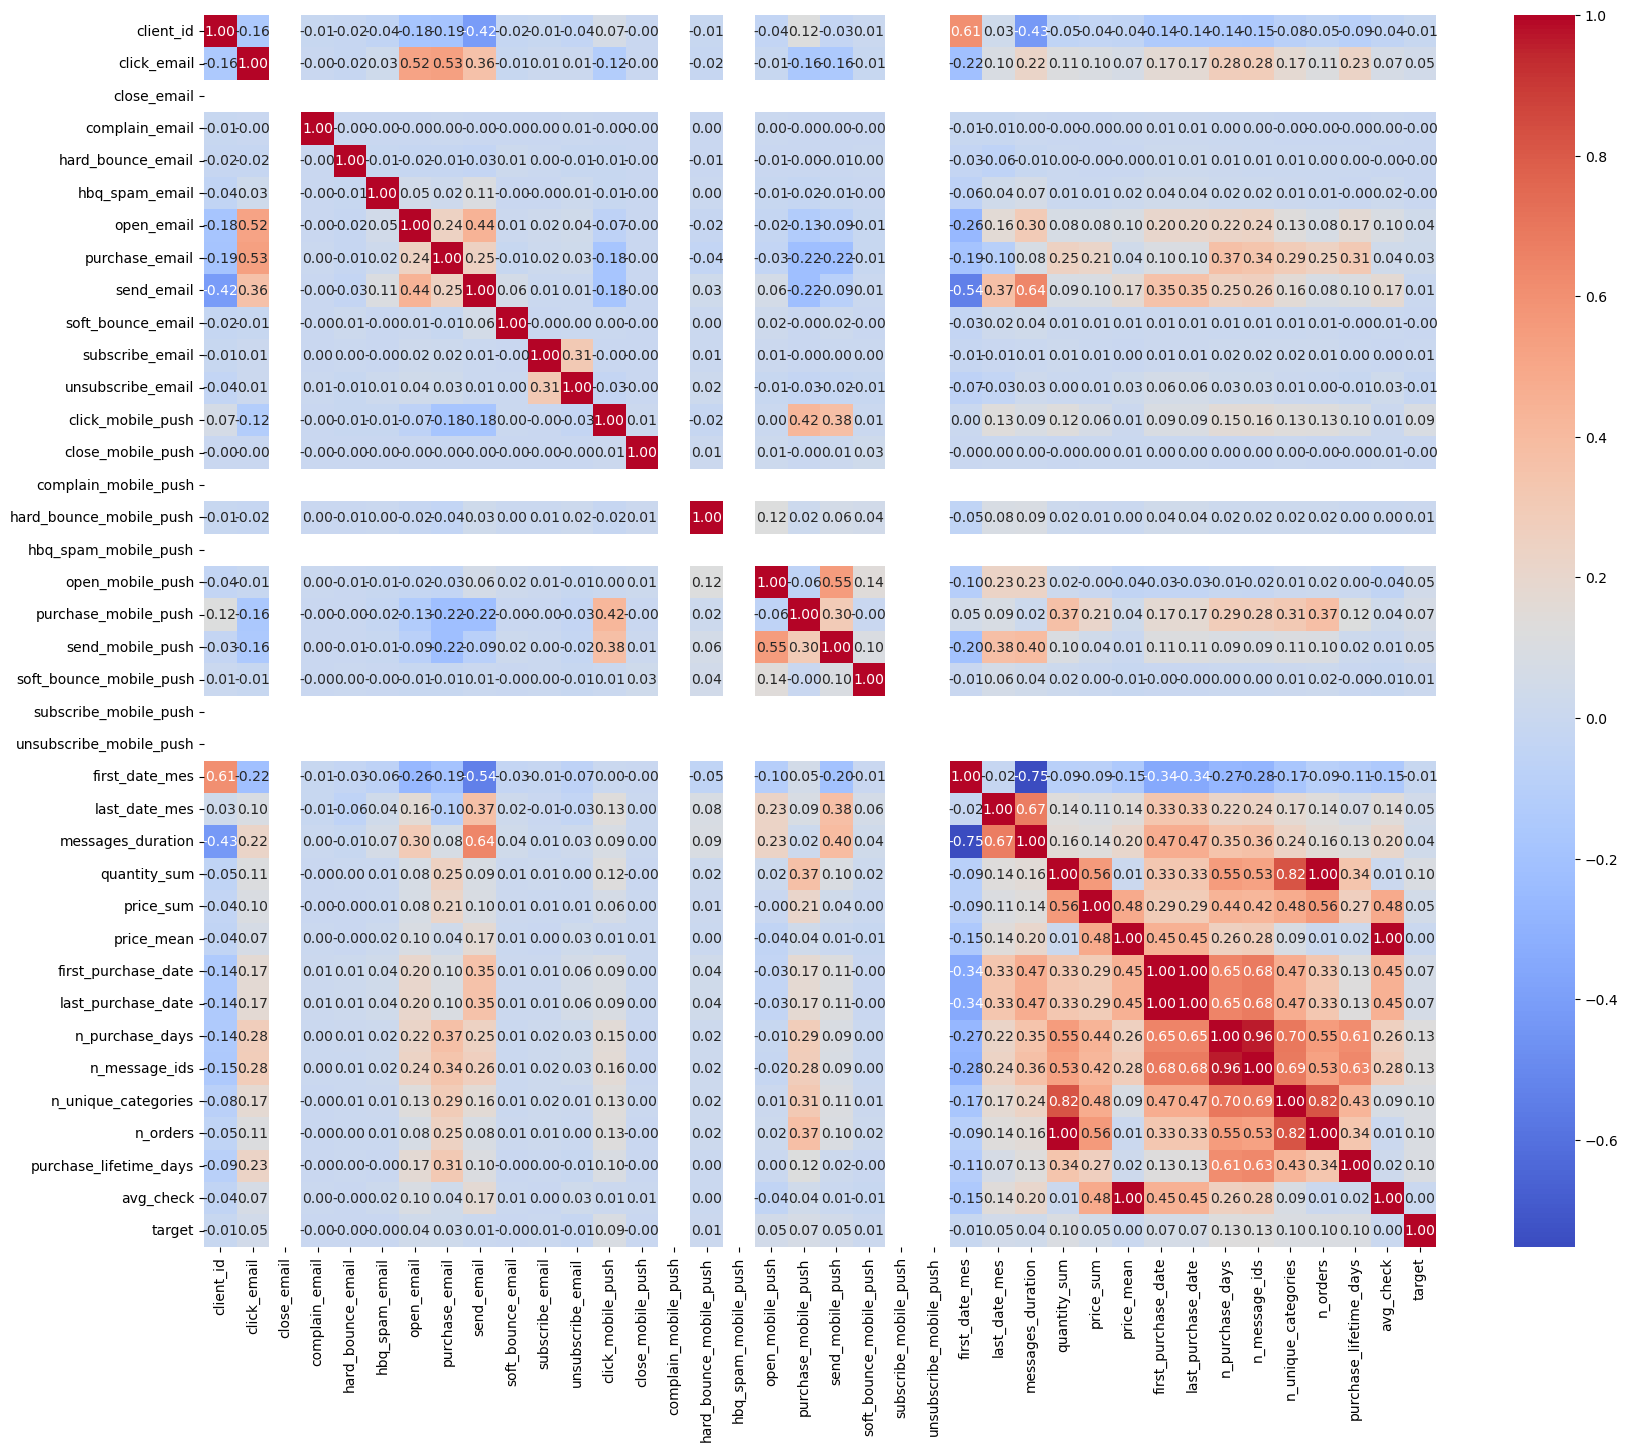

In [185]:

plt.figure(figsize=(20, 16))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.show()


In [186]:

corr_matrix = df.corr().abs()  # абсолютные значения корреляции

# Создаем маску для верхнего треугольника матрицы, чтобы не проверять корреляции дважды и по диагонали
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Находим столбцы, которые нужно убрать (есть корреляция > 0.85 с каким-то другим)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Убираем эти колонки из датафрейма
df = df.drop(columns=to_drop)

print(f"Удалено колонок из-за высокой корреляции: {to_drop}")


Удалено колонок из-за высокой корреляции: ['last_purchase_date', 'n_message_ids', 'n_orders', 'avg_check']


## Обучение моделей

In [187]:
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
print(df[datetime_cols].isnull().sum())


first_date_mes             0
last_date_mes              0
first_purchase_date    11347
dtype: int64


In [189]:
 df['first_purchase_date'] = df['first_purchase_date'].fillna(df['first_date_mes'])
#df['last_purchase_date'] = df['last_purchase_date'].fillna(df['first_date_mes'])


In [190]:
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
print(df[datetime_cols].isnull().sum())

first_date_mes         0
last_date_mes          0
first_purchase_date    0
dtype: int64


In [204]:
df

,client_id,click_email,close_email,complain_email,hard_bounce_email,hbq_spam_email,open_email,purchase_email,send_email,soft_bounce_email,...,last_date_mes,messages_duration,quantity_sum,price_sum,price_mean,first_purchase_date,n_purchase_days,n_unique_categories,purchase_lifetime_days,target
0,1515915625468060902,10,0,0,0,0,35,5,126,0,...,2024-01-19,610 days,7,6993,999,2022-05-27,1,5,0,0
1,1515915625468061003,6,0,0,0,0,5,1,154,0,...,2024-02-13,634 days,7,16235,2319,2023-01-04,1,1,0,1
2,1515915625468061099,8,0,0,0,0,17,0,157,0,...,2024-02-13,635 days,1,299,299,2022-05-17,1,1,0,0
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,2024-02-15,637 days,2,2098,1049,2024-02-10,1,1,0,0
4,1515915625468061170,16,0,0,0,0,19,3,164,0,...,2024-02-15,631 days,19,33601,1768,2023-03-26,3,4,83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0,0,0,0,0,0,0,0,0,...,2024-02-15,0 days,4,568,142,2024-02-13,1,2,0,0
53325,1515915626010221592,0,0,0,0,0,0,0,0,0,...,2024-02-15,0 days,2,2998,1499,2024-02-16,1,1,0,0
53326,1515915626010234726,0,0,0,0,0,0,0,0,0,...,2024-02-15,0 days,0,0,0,2024-02-15,0,0,0,0
53327,1515915626010261344,0,0,0,0,0,0,0,0,0,...,2024-02-15,0 days,6,8994,1499,2024-02-16,1,1,0,0


In [205]:

X = df.drop(columns=['client_id', 'target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [206]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [193]:

print("До оверсэмплинга:", np.bincount(y_train))
print("После оверсэмплинга:", np.bincount(y_train_resampled))


До оверсэмплинга: [41986   677]
После оверсэмплинга: [41986 41986]


In [207]:

print("До оверсэмплинга:", np.bincount(y_train))
print("После оверсэмплинга:", np.bincount(y_train_resampled))


До оверсэмплинга: [41986   677]
После оверсэмплинга: [41986 41986]


In [208]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83972 entries, 0 to 83971
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   click_email              83972 non-null  int64          
 1   close_email              83972 non-null  int64          
 2   complain_email           83972 non-null  int64          
 3   hard_bounce_email        83972 non-null  int64          
 4   hbq_spam_email           83972 non-null  int64          
 5   open_email               83972 non-null  int64          
 6   purchase_email           83972 non-null  int64          
 7   send_email               83972 non-null  int64          
 8   soft_bounce_email        83972 non-null  int64          
 9   subscribe_email          83972 non-null  int64          
 10  unsubscribe_email        83972 non-null  int64          
 11  click_mobile_push        83972 non-null  int64          
 12  close_mobile_push 

### 1 модель: catboost

In [209]:


cat_model = catboost.CatBoostClassifier(
    iterations=30,
    learning_rate=0.05,
    depth=6,
    verbose=100,
    random_seed=42,
    #eval_metric='F1',
    eval_metric='AUC',
    task_type='CPU'
)

cat_model.fit(
    X_train_resampled, y_train_resampled,
    #cat_features=categorical_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

0:	test: 0.7638336	best: 0.7638336 (0)	total: 16.5ms	remaining: 479ms
29:	test: 0.8171410	best: 0.8194781 (26)	total: 264ms	remaining: 0us

bestTest = 0.819478149
bestIteration = 26

Shrink model to first 27 iterations.


In [210]:
y_proba = cat_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.8195


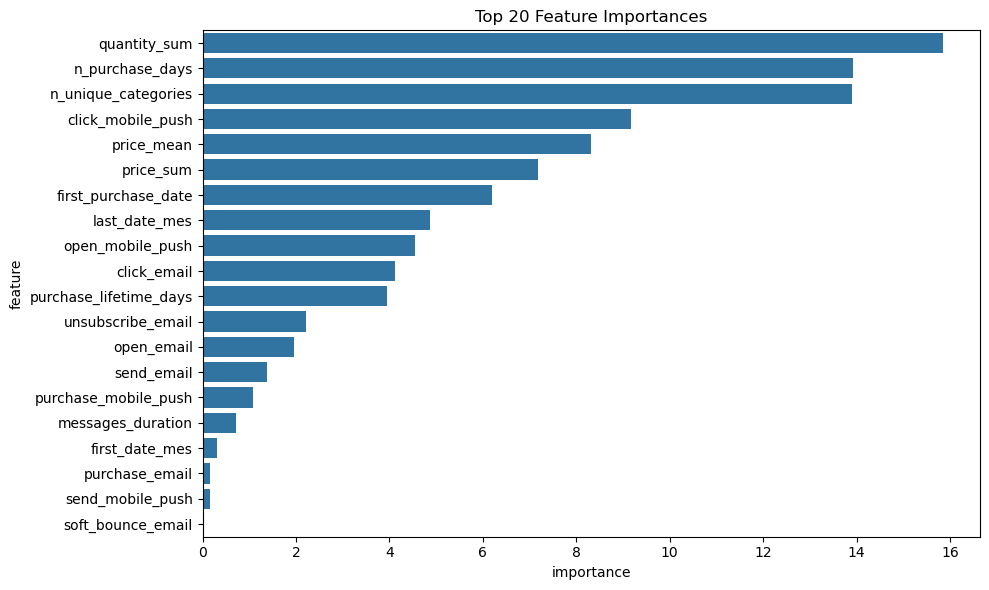

In [211]:
importances = cat_model.get_feature_importance()

# Имена признаков
feature_names = X_train_resampled.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

#print(feat_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

- **Основные драйверы:**  
  - Суммарное количество товаров (`quantity_sum`)  
  - Количество дней с покупками (`n_purchase_days`)  
  - Разнообразие категорий товаров (`n_unique_categories`)  

- **Важные ценовые признаки:**  
  - Средняя цена (`price_mean`)  
  - Общая сумма покупок (`price_sum`)  

- **Временные признаки:**  
  - Дата первой покупки (`first_purchase_date`)  
  - Дата последнего взаимодействия (`last_date_mes`)  

- **Активность в рассылках:**  
  - Клики и открытия по мобильным push и email (`click_mobile_push`, `open_mobile_push`, `click_email`, `unsubscribe_email`, `open_email`)  

- **Низкая значимость:**  
  - Подписки на push (`subscribe_mobile_push`) и некоторые другие признаки  

---

**Вывод:**  
Вероятность покупки определяют в первую очередь покупательская активность, ценовые параметры и вовлечённость в коммуникацию.

### 2 модель: лог. регрессия

In [212]:
X_train_clean = X_train_resampled.drop(columns=[
    'first_date_mes', 'last_date_mes', 'messages_duration', 
    'first_purchase_date'
])
X_test_clean = X_test.drop(columns=[
    'first_date_mes', 'last_date_mes', 'messages_duration', 
    'first_purchase_date'
])

In [215]:
model2 = LogisticRegression(max_iter=1000, random_state=42)
model2.fit(X_train_clean, y_train_resampled)


/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [216]:

y_pred2 = model2.predict(X_test_clean)
y_proba2 = model2.predict_proba(X_test_clean)[:, 1]

# Оценка модели
print('ROC AUC:', roc_auc_score(y_test, y_proba2))


ROC AUC: 0.748195736961758


In [218]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83     10497
           1       0.04      0.64      0.07       169

    accuracy                           0.72     10666
   macro avg       0.51      0.68      0.45     10666
weighted avg       0.98      0.72      0.82     10666



/var/folders/0p/n2w1q9g52tx67x3r14sn_ptc0000gn/T/ipykernel_28879/1236801743.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef_abs', y='feature', data=coef_df2.head(20), palette='viridis')


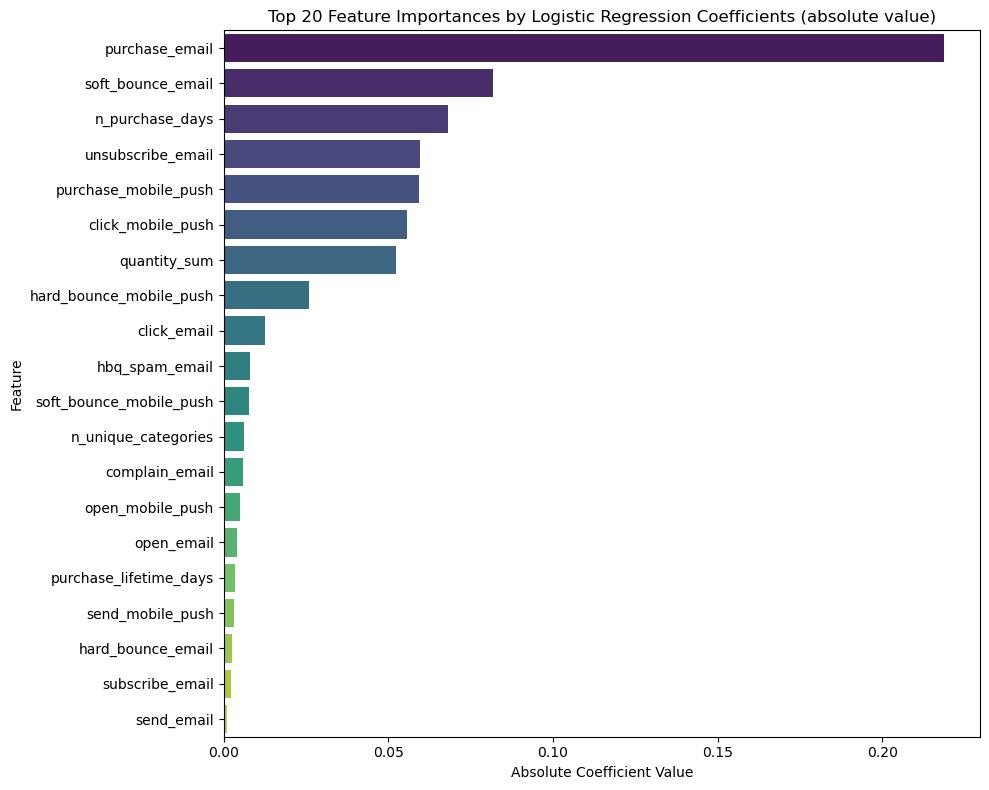

In [220]:
# Получаем коэффициенты модели
coefs2 = model2.coef_[0]  # для бинарной классификации

# Имена признаков
feature_names2 = X_test_clean.columns

# Создаем DataFrame с признаками и абсолютными значениями коэффициентов
coef_df2 = pd.DataFrame({
    'feature': feature_names2,
    'coef_abs': np.abs(coefs2),
    'coef': coefs2
})

# Сортируем по абсолютному значению коэффициента
coef_df2 = coef_df2.sort_values(by='coef_abs', ascending=False)

# Визуализация топ-20 признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='coef_abs', y='feature', data=coef_df2.head(20), palette='viridis')
plt.title('Top 20 Feature Importances by Logistic Regression Coefficients (absolute value)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 3 модель: LGBM

In [164]:


model3 = lgb.LGBMClassifier(random_state=42, n_estimators=1000, n_jobs=-1)

model3.fit(
    X_train_clean,
    y_train_resampled,
    eval_set=[(X_test_clean, y_test)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=150), log_evaluation(300)]
)



[LightGBM] [Info] Number of positive: 41986, number of negative: 41986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 83972, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.795267	valid_0's binary_logloss: 0.571765


LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [165]:
y_pred3 = model3.predict(X_test_clean)          # классы
y_proba3 = model3.predict_proba(X_test_clean)[:, 1]  # вероятности класса 1
roc_auc3 = roc_auc_score(y_test, y_proba3)
print('ROC AUC:', roc_auc_score(y_test, y_proba3))

ROC AUC: 0.7952669486294478


                    feature  importance
25               price_mean          24
12        click_mobile_push          22
17         open_mobile_push          16
23             quantity_sum          16
6                open_email          16
0                 client_id          15
1               click_email          11
24                price_sum          11
8                send_email          10
19         send_mobile_push           9
30   purchase_lifetime_days           8
15  hard_bounce_mobile_push           7
11        unsubscribe_email           6
29                 n_orders           5
28      n_unique_categories           2
20  soft_bounce_mobile_push           1
27            n_message_ids           1
26          n_purchase_days           0
22  unsubscribe_mobile_push           0
21    subscribe_mobile_push           0
16     hbq_spam_mobile_push           0
18     purchase_mobile_push           0
14     complain_mobile_push           0
13        close_mobile_push           0


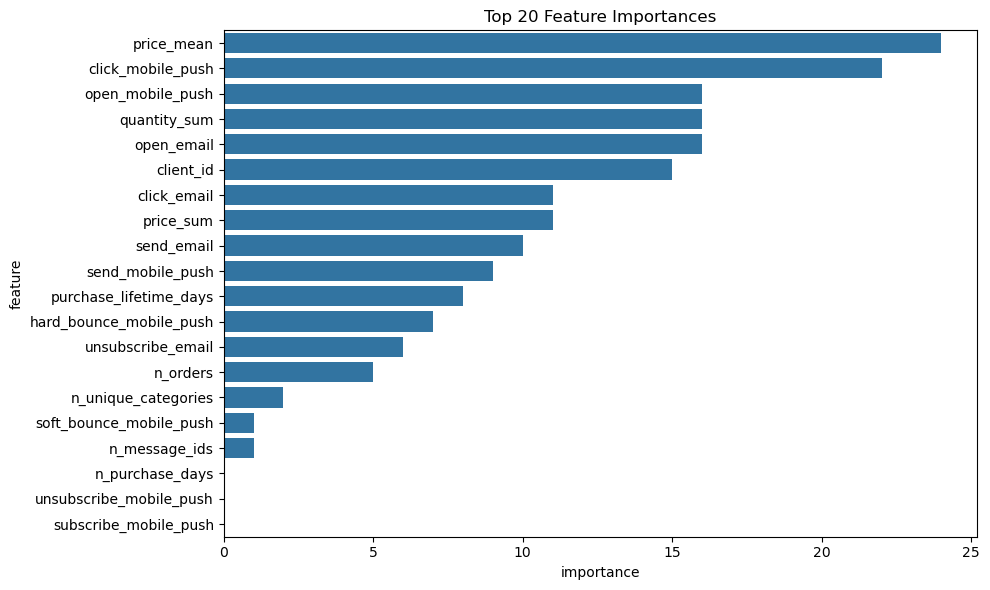

In [199]:
# Получение важности признаков
importances3 = model3.feature_importances_

# Имена признаков
feature_names3 = X_train_clean.columns

# Создаем DataFrame для удобства
feat_imp3 = pd.DataFrame({'feature': feature_names3, 'importance': importances3})
feat_imp3 = feat_imp3.sort_values(by='importance', ascending=False)

print(feat_imp3)

# Визуализация (топ-20 признаков)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp3.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

### 4 модель catboost 2

In [166]:


cat_model2 = catboost.CatBoostClassifier(
    iterations=30,
    learning_rate=0.05,
    depth=6,
    verbose=100,
    random_seed=42,
    #eval_metric='F1',
    eval_metric='AUC',
    task_type='CPU'
)

cat_model2.fit(
    X_train_clean, y_train_resampled,
    #cat_features=categorical_features,
    eval_set=(X_test_clean, y_test),
    early_stopping_rounds=50
)

0:	test: 0.7768762	best: 0.7768762 (0)	total: 21.3ms	remaining: 617ms
29:	test: 0.7947407	best: 0.7970869 (17)	total: 270ms	remaining: 0us

bestTest = 0.7970868543
bestIteration = 17

Shrink model to first 18 iterations.


In [167]:
y_proba4 = cat_model2.predict_proba(X_test_clean)[:, 1]

roc_auc4 = roc_auc_score(y_test, y_proba4)
print(f"ROC AUC: {roc_auc4:.4f}")

ROC AUC: 0.7971


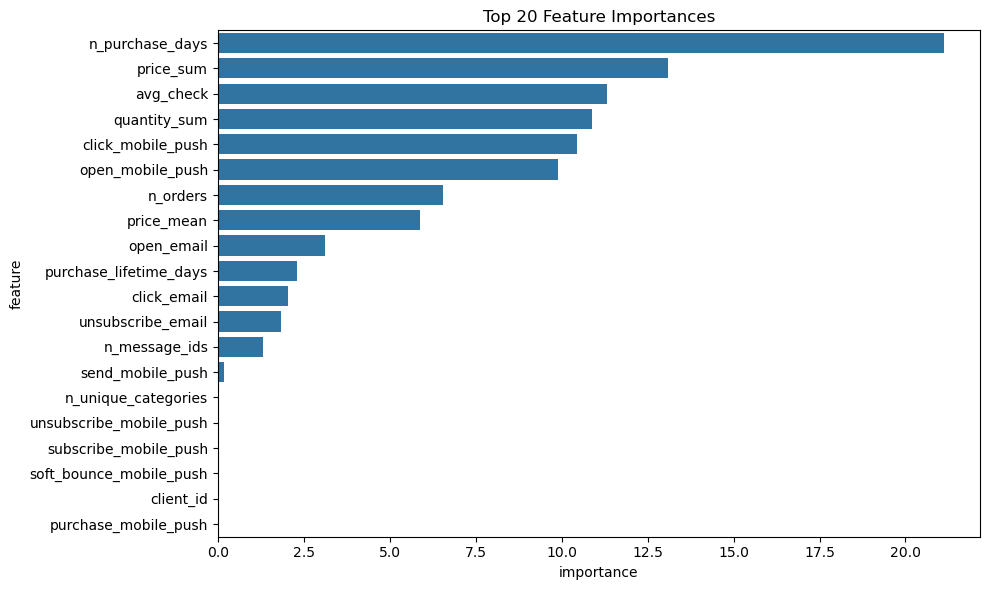

In [202]:
importances2 = cat_model2.get_feature_importance()

# Имена признаков
feature_names2 = X_train_clean.columns

feat_imp2 = pd.DataFrame({'feature': feature_names2, 'importance': importances2})
feat_imp2 = feat_imp2.sort_values(by='importance', ascending=False)

#print(feat_imp2)


plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp2.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

## 5 модель Support Vector Classification

In [222]:
from sklearn.svm import SVC

model5 = SVC(kernel='rbf', probability=True, random_state=42)

model5.fit(X_train_clean, y_train_resampled)

# Предсказываем вероятности на тесте
y_proba5 = model5.predict_proba(X_test_clean)[:, 1]

# Предсказываем метки классов
y_pred5 = model5.predict(X_test_clean)

# Оцениваем качество (ROC AUC)
auc_score5 = roc_auc_score(y_test, y_proba5)
print(f"ROC AUC: {auc_score5:.4f}")

ROC AUC: 0.7256


## 6 модель: kNN

In [223]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Создаем модель KNN с числом соседей k=5 
model6 = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Обучаем модель
model6.fit(X_train_clean, y_train_resampled)

# Предсказываем вероятности положительного класса
y_proba6 = model6.predict_proba(X_test_clean)[:, 1]

# Предсказываем метки классов
y_pred6 = model6.predict(X_test_clean)

# Оцениваем качество (ROC AUC)
auc_score6 = roc_auc_score(y_test, y_proba6)
print(f'ROC AUC: {auc_score6:.4f}')


ROC AUC: 0.5403
